# Laboratorium 4 - rekomendacje dla portali informacyjnych

## Przygotowanie

 * pobierz i wypakuj dataset: https://mind201910small.blob.core.windows.net/release/MINDsmall_train.zip
   * więcej możesz poczytać tutaj: https://learn.microsoft.com/en-us/azure/open-datasets/dataset-microsoft-news
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab4`
 * zainstaluj potrzebne biblioteki:
 `pip install nltk sklearn`

## Część 1. - przygotowanie danych

In [1]:
# importujemy wszystkie potrzebne pakiety

import codecs
from collections import defaultdict # mozesz uzyc zamiast zwyklego slownika, rozwaz wplyw na czas obliczen
import math
import re
from string import punctuation

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

# mozesz uzyc do obliczania najbardziej podobnych tekstow zamiast liczenia "na piechote"
# ale pamietaj o dostosowaniu formatu danych
from sklearn.neighbors import NearestNeighbors

# na potrzeby wizualizacji
import matplotlib.pyplot as plt
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# definiujemy potrzebne zmienne

PATH = './MINDsmall_train'
STOPWORDS = set(stopwords.words('english'))

In [5]:
# wczytujemy metadane artykułów

def parse_news_entry(entry):
    news_id, category, subcategory, title, abstract = entry.split('\t')[:5]
    return {
        'news_id': news_id,
        'category': category,
        'subcategory': subcategory,
        'title': title,
        'abstract': abstract
    }

def get_news_metadata():
    with codecs.open(f'{PATH}/news.tsv', 'r', 'UTF-8') as f:
        raw = [x for x in f.read().split('\n') if x]
        parsed_entries = [parse_news_entry(entry) for entry in raw]
        return {x['news_id']: x for x in parsed_entries}

news = get_news_metadata()
news_ids = sorted(list(news.keys()))
news_indices = {x[1]: x[0] for x in enumerate(news_ids)}
print(len(news))

51282


In [6]:
def parse_history_entry(entry):
    _id, user_id, _time, history, _impressions = entry.split('\t')
    history = [x for x in history.split() if x]
    return user_id, history

def get_users_history():
    with codecs.open(f'{PATH}/behaviors.tsv', 'r', 'UTF-8') as f:
        lines = [x for x in f.read().split('\n') if x]
        entries = [parse_history_entry(x) for x in lines]
        return dict(entries)

users_history = get_users_history()
test_users = 'U53231', 'U89744', 'U10045', 'U92486', 'U70879'
print(len(users_history))

50000


## Część 2. - TF-IDF

In [7]:
# normalizujemy teksty na potrzeby dalszego przetwarzania
import nltk
nltk.download('rslp')

def preprocess_text(text):
    # zamieniamy wszystkie ciagi bialych znakow na pojedyncze spacje
    preprocessed = re.sub(r'\s+', ' ', text)
    # usuwamy znaki interpunkcyjne
    preprocessed = re.sub(f'[{punctuation}]', '', text)
    # usuwamy wszystkie liczby
    preprocessed = re.sub(r'\d+', '', preprocessed)
    # podmieniamy wszystkie wielkie litery
    preprocessed = preprocessed.lower()
    # dzielimy na tokeny
    preprocessed = preprocessed.split()
    # usuwamy stopwords
    preprocessed = [x for x in preprocessed if x not in STOPWORDS]
    return preprocessed

def stem_texts(corpus):
    # Reducing words to shoster forms
    # "I think we have a really good team, and a team that can really do some special, good things because that group is very close in there." - Brian Schmetzer
    # think realli good team team realli special good thing group close brian schmetzer
    stemmer = SnowballStemmer('english')

    # think really good te te really spec good thing group clos brian schmetz
    # stemmer = RSLPStemmer()

    # think real good team team real spec good thing group clos bri schmetzer
    # stemmer = LancasterStemmer()

    # think realli good team team realli special good thing group close brian schmetzer
    # stemmer = PorterStemmer()

    return [[stemmer.stem(word) for word in preprocess_text(text)] for text in corpus]

texts = [news[news_id]['abstract'] for news_id in news_ids]
stemmed_texts = stem_texts(texts)

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [8]:
# porownajmy teksty przed i po przetworzeniu

print(texts[2] + '\n')
print(' '.join(stemmed_texts[2]))

"I think we have a really good team, and a team that can really do some special, good things because that group is very close in there." - Brian Schmetzer

think realli good team team realli special good thing group close brian schmetzer


In [9]:
# tworzymy liste wszystkich slow w korpusie

def get_all_words_sorted(corpus):
    # generujemy posortowana alfabetycznie liste wszystkich slow (tokenow)
    return sorted(list(set([word for text in corpus for word in text])))

wordlist = get_all_words_sorted(stemmed_texts)
word_indices = {x[1]: x[0] for x in enumerate(wordlist)}
print(len(wordlist))

41852


In [10]:
# obliczamy liczbe tekstow, w ktorych wystapilo kazde ze slow
# pamietaj, ze jesli slowo wystapilo w danym tekscie wielokrotnie, to liczymy je tylko raz

def get_document_frequencies(corpus, wordlist):
    # return {word -> count}
    per_word_frequency = defaultdict(lambda: 0)
    for text in corpus:
        unique_words = set()
        for word in text:
            if word not in unique_words:
                per_word_frequency[word] += 1
                unique_words.add(word)
    return per_word_frequency

document_frequency = get_document_frequencies(stemmed_texts, wordlist)

In [11]:
# obliczamy liczbe wystapien kazdego slowa w kazdym tekscie

def get_term_frequencies(corpus, news_indices):
    # return {news_id -> {word -> count}}
    return {news_id: {word: text.count(word) for word in text} for news_id, text in zip(news_indices, corpus)}

term_frequency = get_term_frequencies(stemmed_texts, news_indices)

In [12]:
# sprawdzmy wyniki

term_frequency[news_ids[2]]

{'think': 1,
 'realli': 2,
 'good': 2,
 'team': 2,
 'special': 1,
 'thing': 1,
 'group': 1,
 'close': 1,
 'brian': 1,
 'schmetzer': 1}

In [13]:
# obliczamy metryke tf_idf

# Liczby podobienstwo tekstów na podstawie liczby tokenów (podobne bo mówią o podobnych rzeczach)
# daje nam np k najlepszych tresci / najpodobniejszych
# prosta miara dla kazdego slowa x i tekstu y
# Wxy = TFxy * log(N/DFx)
# TF - times frequency
# N - liczba dokumentów
# DFx - liczba testków zawierajcych x-a

def calculate_tf_idf(term_frequency, document_frequency, corpus_size):
    results = {news_id: dict() for news_id in term_frequency}
    for news_id, count_per_word in term_frequency.items():
        for word, count in count_per_word.items():
            results[news_id][word] = count * math.log(corpus_size / document_frequency[word])
    return results


tf_idf = calculate_tf_idf(term_frequency, document_frequency, len(news_ids))

In [14]:
# sprawdzmy wyniki

tf_idf[news_ids[2]]

{'think': 4.360459856758821,
 'realli': 9.707261090572182,
 'good': 8.085400658139525,
 'team': 6.157356388748834,
 'special': 4.765161897298483,
 'thing': 4.111693200556713,
 'group': 4.261685870235309,
 'close': 3.9244235881453897,
 'brian': 5.624739267315748,
 'schmetzer': 9.458800731274183}

## Część 3. - Podobieństwo tekstów

In [15]:
# obliczmy odleglosc miedzy dwoma artykulami # maciez podobieństwa
# przetestuj rozne metryki odleglosci i wybierz najlepsza

def calculate_distance(tf_idf, id1, id2, metric="euclidean"):
    if id2 not in tf_idf or id1 not in tf_idf:
        return 0
    if metric == 'euclidean':
        return math.sqrt(sum([(tf_idf[id1][word] - tf_idf[id2][word]) ** 2 for word in tf_idf[id1] if word in tf_idf[id2]]))
    elif metric == 'cosine':
        return sum([tf_idf[id1][word] * tf_idf[id2][word] for word in tf_idf[id1] if word in tf_idf[id2]]) / (math.sqrt(sum([tf_idf[id1][word] ** 2 for word in tf_idf[id1]])) * math.sqrt(sum([tf_idf[id2][word] ** 2 for word in tf_idf[id2]])))

print("Euclidian:", calculate_distance(tf_idf, news_ids[2], news_ids[1]))
print("Cosine:", calculate_distance(tf_idf, news_ids[2], news_ids[1], 'cosine'))

Euclidian: 3.078678194374417
Cosine: 0.024707226338299554


In [16]:
# funkcja pomocnicza do wyswietlania artykulow
def print_news_entry(n_id, corpus):
    print(f'id: {n_id}\n\ttitle: {corpus[n_id]["title"]}\n\ttext: {corpus[n_id]["abstract"]}')

print_news_entry('N42782', news)

id: N42782
	title: Three takeaways from Yankees' ALCS Game 5 victory over the Astros
	text: The Yankees kept hope alive thanks to some impressive starting pitching and a pair of early home runs.


In [17]:
# wyznaczmy k najpodobniejszych tekstow do danego
# pamietaj o odpowiedniej kolejnosci sortowania w zaleznosci od wykorzystanej metryki
# pamietaj, zeby wsrod podobnych tekstow nie bylo danego

def get_k_most_similar_news(tf_idf, n_id, k):
    distances = [(calculate_distance(tf_idf, n_id, n_id2, 'euclidean'), n_id2) for n_id2 in news_ids if n_id != n_id2]
    distances.sort(key=lambda x: x[0], reverse=True)
    return [x[1] for x in distances[:k]]

def print_k_most_similar_news(tf_idf, n_id, k, corpus):
    similar = get_k_most_similar_news(tf_idf, n_id, k)
    print_news_entry(n_id, corpus)
    print(f'\n{k} most similar:')
    for s_id in similar:
       print_news_entry(s_id, corpus)

print_k_most_similar_news(tf_idf, news_ids[42337], 5, news)

id: N58544
	title: Tiny Electric Car Cost $420,000 To Build
	text: A MAN claims he has created a car that might solve the world's traffic congestion problems. Rick Woodbury from Spokane, Washington USA, is the president, founder and sole employee of 'Commuter Cars.' The carmaker's flagship model is the 2005 super slim two-seater Tango T600, a high-performance electric car that preceded Tesla. Rick told BTV: "I started this company 21 years ago   it was based on an idea that I came up with in 1982." He was inspired by the shocking traffic congestion he had to face on a daily basis. "I used to drive a Porsche from Beverly Hills to Hermosa Beach every day and the traffic was horrendous," explained Rick. What really made Rick think about a solution was the fact that in most of the cars he would see in his commute were occupied by lone drivers. "I noticed that everybody around me was a single occupant in a car, taking up the whole lane," Rick said. Living and working in Los Angeles also hel

## Część 4. - Profile użytkowników

In [18]:
# oblicz srednia z wektorow tf-idf artykulow o zadanych id-kach
def calculate_average_vector(tf_idf, news_ids: list[str]) -> dict[str, float]:
    if not news_ids:
        return {}

    sum_tf_idf = {}

    for news_id in news_ids:
        article_tf_idf = tf_idf.get(news_id, {})
        for word, value in article_tf_idf.items():
            sum_tf_idf[word] = sum_tf_idf.get(word, 0.0) + value

    # Obliczenie średniej TF-IDF
    average_tf_idf = {word: total / len(news_ids) for word, total in sum_tf_idf.items()}

    return average_tf_idf

# wykorzystaj powyzsza funkcje, by policzyc wektor kazdego uzytkownika
def calculate_users_vectors(tf_idf, users_history) -> dict[str, list]:
    users_vectors = {}
    for user_id, news_ids in users_history.items():
        average_vector = calculate_average_vector(tf_idf, news_ids)
        users_vectors[user_id] = average_vector
    return users_vectors

user_vectors = calculate_users_vectors(tf_idf, users_history)


In [19]:
# sprawdz wyliczony profil dla przykladowego uzytkownika
print(sorted([(k,v) for k,v in user_vectors[test_users[0]].items() if v], key=lambda x: -x[1]))

[('fire', 1.2681134975375898), ('plane', 1.1701285777724966), ('ditch', 1.0497982187039419), ('diaz', 0.9848359105446637), ('land', 0.8870284483240061), ('paula', 0.8214687066477994), ('acr', 0.8090445060145697), ('ventura', 0.7780260164933531), ('mcconnel', 0.76945001209976), ('flight', 0.7527351413211081), ('maria', 0.7407074421074729), ('hailston', 0.7251391365595806), ('aircraft', 0.7197815043588195), ('storm', 0.6912488475417629), ('chaser', 0.6756286236624416), ('tornado', 0.6380084961613199), ('noaa', 0.6261181107653027), ('report', 0.6253912485455763), ('twoweek', 0.6177050367898467), ('airlin', 0.611710355929694), ('story', 0.6009271210247275), ('contain', 0.5981148110881273), ('california', 0.5954302330209911), ('santa', 0.5734321766843061), ('may', 0.5473113739405064), ('accord', 0.5430078051546358), ('ef', 0.5366350415870621), ('tanker', 0.5317069793379942), ('larg', 0.5301365597954284), ('mandatori', 0.5227667548412794), ('behind', 0.5071744020955066), ('mitch', 0.49813529

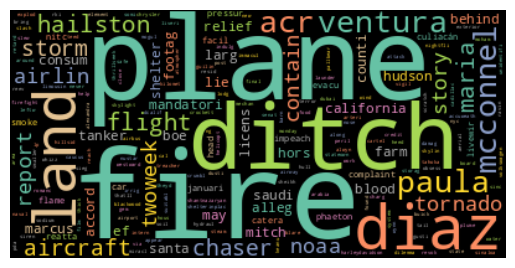

In [20]:
# skorzystajmy ze znanej juz biblioteki, by to lepiej zwizualizowac
def plot_vector(tf_idf_vector):
    wordcloud = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud.generate_from_frequencies(frequencies=tf_idf_vector)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

plot_vector(user_vectors[test_users[0]])

## Część 5. - Rekomendacje dla użytkowników

Historia użytkownika:
['N47823', 'N44013', 'N17354', 'N26531', 'N22570', 'N16215', 'N29849', 'N42989', 'N57147', 'N47069', 'N64952', 'N27448', 'N45589', 'N8391', 'N52109', 'N41252', 'N32299', 'N51111', 'N30847', 'N43369', 'N63221', 'N65219', 'N39647', 'N64408', 'N14607', 'N39584', 'N32187', 'N29316', 'N63740', 'N2234', 'N42208', 'N28296', 'N20742', 'N57537', 'N54793', 'N50890', 'N7203', 'N36699', 'N61598', 'N42946', 'N34595', 'N49513', 'N29197', 'N33969', 'N13361', 'N60333', 'N24131', 'N63054', 'N47954', 'N41433', 'N50467', 'N61018', 'N46194', 'N36030', 'N45896', 'N33704', 'N51180', 'N26119', 'N45896', 'N57783', 'N28144', 'N49528', 'N16513', 'N54826', 'N57109', 'N25732', 'N46909', 'N42664', 'N3124', 'N42359', 'N29851', 'N37920', 'N59691', 'N3471', 'N28425', 'N35', 'N1506', 'N64706', 'N38585', 'N61388', 'N52652', 'N3388', 'N39084', 'N28058', 'N9012', 'N40809', 'N45909', 'N45954', 'N40467', 'N33389', 'N53385', 'N38562', 'N30374', 'N15587', 'N42358', 'N31111', 'N13400', 'N15587', 'N17764'

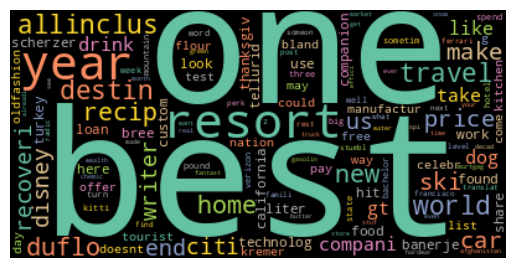


Rekomendacje dla użytkownika U70879:
id: N56704
	title: Our 50 Favorite Recipes of 2019
	text: 2019 might have been our most delicious year yet! Check out new recipes and some of our most popular dishes from the past year. The post Our 50 Favorite Recipes of 2019 appeared first on Taste of Home.
id: N37092
	title: Illegal Notion: Sunday...Funday...?
	text: The Best Sunday of the Year
id: N40194
	title: Charlotte offers first responders, teachers money to buy homes
	text: A new initiative by the city of Charlotte offers first responders and teachers money to help buy a house in Mecklenburg County. The move comes as home prices skyrocket. To give you some perspective, a person making $20 an hour would need to work 60 hours just to make enough to pay one month's average rent. So even if you make a decent living, how do you save up for the down payment on a house? For some members of our community who are used to...
id: N54926
	title: 30 New Twists on Thanksgiving Favorites
	text: Bored o

In [29]:
# wykorzystujac wektory tresci i profile uzytkownikow,
#   wygeneruj liste k artykulow najlepiej dopasowanych do uzytkownika
#   pamietaj o odsianiu artykulow, ktore uzytkownik juz kliknal

def calculate_distance_user(tf_idf, id1, vector2, metric="euclidean"):
    # Check if id1 (the article ID) exists in the TF-IDF dictionary
    if id1 not in tf_idf:
        return float('inf')  # Return a large value if the article ID is not found

    vector1 = tf_idf[id1]  # Get the TF-IDF vector for the article

    if metric == 'euclidean':
        # Calculate Euclidean distance
        distance = math.sqrt(sum([(vector1.get(word, 0) - vector2.get(word, 0)) ** 2
                                   for word in set(vector1) | set(vector2)]))
    elif metric == 'cosine':
        # Calculate Cosine similarity
        dot_product = sum([vector1.get(word, 0) * vector2.get(word, 0) for word in vector1])
        magnitude1 = math.sqrt(sum([value ** 2 for value in vector1.values()]))
        magnitude2 = math.sqrt(sum([value ** 2 for value in vector2.values()]))

        # Avoid division by zero
        if magnitude1 == 0 or magnitude2 == 0:
            return float('inf')  # Return a large value if either vector is zero

        distance = 1 - (dot_product / (magnitude1 * magnitude2))  # Cosine distance
    else:
        raise ValueError("Unsupported metric: {}".format(metric))

    return distance


def recommend(tf_idf, user_id, news, users_history, k, metric='cosine'):
    # Sprawdź, czy użytkownik ma profil
    if user_id not in user_vectors:
        return []

    user_vector = user_vectors[user_id]  # Średni wektor użytkownika

    # Lista ID artykułów, które użytkownik kliknął
    clicked_news_ids = users_history[user_id]

    # Lista przechowująca wyniki rekomendacji (tupar: (odległość, id artykułu))
    recommendations = []

    for news_id in news:
        if news_id not in clicked_news_ids:
            # Oblicz odległość między wektorem użytkownika a wektorem artykułu
            distance = calculate_distance_user(tf_idf, news_id, user_vector, metric)
            recommendations.append((distance, news_id))

    # Sortuj rekomendacje według odległości (najmniejsza odległość na początku)
    recommendations.sort(key=lambda x: x[0])

    # Zwróć k najlepszych rekomendacji
    return [news_id for _, news_id in recommendations[:k]]

# Przykład użycia
user_id = test_users[4]  # Wybierz przykładowego użytkownika
k = 5  # Liczba rekomendacji

recommended_articles = recommend(tf_idf, user_id, news_ids, users_history, k)

# Wyświetlenie historii użytkownika, profilu i rekomendacji
print("Historia użytkownika:")
print(users_history[user_id])

print("\nProfil użytkownika:")
plot_vector(user_vectors[user_id])

print(f"\nRekomendacje dla użytkownika {user_id}:")
for article_id in recommended_articles:
    print_news_entry(article_id, news)


Historia użytkownika:
['N47823', 'N44013', 'N17354', 'N26531', 'N22570', 'N16215', 'N29849', 'N42989', 'N57147', 'N47069', 'N64952', 'N27448', 'N45589', 'N8391', 'N52109', 'N41252', 'N32299', 'N51111', 'N30847', 'N43369', 'N63221', 'N65219', 'N39647', 'N64408', 'N14607', 'N39584', 'N32187', 'N29316', 'N63740', 'N2234', 'N42208', 'N28296', 'N20742', 'N57537', 'N54793', 'N50890', 'N7203', 'N36699', 'N61598', 'N42946', 'N34595', 'N49513', 'N29197', 'N33969', 'N13361', 'N60333', 'N24131', 'N63054', 'N47954', 'N41433', 'N50467', 'N61018', 'N46194', 'N36030', 'N45896', 'N33704', 'N51180', 'N26119', 'N45896', 'N57783', 'N28144', 'N49528', 'N16513', 'N54826', 'N57109', 'N25732', 'N46909', 'N42664', 'N3124', 'N42359', 'N29851', 'N37920', 'N59691', 'N3471', 'N28425', 'N35', 'N1506', 'N64706', 'N38585', 'N61388', 'N52652', 'N3388', 'N39084', 'N28058', 'N9012', 'N40809', 'N45909', 'N45954', 'N40467', 'N33389', 'N53385', 'N38562', 'N30374', 'N15587', 'N42358', 'N31111', 'N13400', 'N15587', 'N17764'

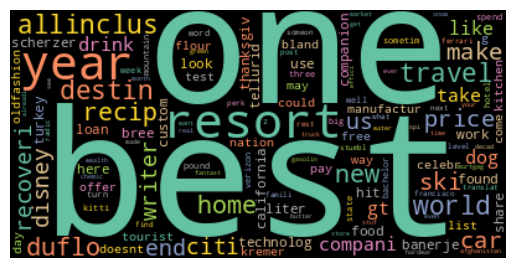


Rekomendacje dla użytkownika U70879:
id: N10062
	title: Report: Bengals bench QB Andy Dalton on his birthday
	text: 
id: N10085
	title: Predictability and the Cleveland Browns Offense
	text: 
id: N10098
	title: Rivalry watch: ESPN in love with the 49ers two weeks before showdown
	text: 
id: N10152
	title: Alex Anthopoulos investigation proves the MLBPA is watching and will be heard
	text: 
id: N1017
	title: President Trump arrives in NYC to attend Veterans Day Parade
	text: 


In [30]:
recommended_articles = recommend(tf_idf, user_id, news_ids, users_history, k, "euclidean")

# Wyświetlenie historii użytkownika, profilu i rekomendacji
print("Historia użytkownika:")
print(users_history[user_id])

print("\nProfil użytkownika:")
plot_vector(user_vectors[user_id])

print(f"\nRekomendacje dla użytkownika {user_id}:")
for article_id in recommended_articles:
    print_news_entry(article_id, news)


## Część 6. - Ocena jakości

In [31]:
def jaccard(v1, v2):
    # Initialize intersection and union sums
    intersection_sum = 0
    union_sum = 0

    # Create a set of all unique words in both vectors
    all_keys = set(v1.keys()).union(set(v2.keys()))

    for key in all_keys:
        # For each word, calculate the contribution to intersection and union
        intersection_sum += min(v1.get(key, 0), v2.get(key, 0))
        union_sum += max(v1.get(key, 0), v2.get(key, 0))

    # To avoid division by zero
    if union_sum == 0:
        return 0.0  # or return 1.0 depending on how you want to handle the empty case

    # Calculate and return the Jaccard index
    return intersection_sum / union_sum


In [32]:
# dla kazdego uzytkownika wygeneruj k-elementowa rekomendacje
# policz jaccard index miedzy wektorem uzytkownika a srednim wektorem elementow z rekomendacji
# porownaj wyniki dla dwoch roznych k i dwoch roznych metryk podobienstwa

for user in test_users:
    for k in [5, 10]:
        for metric in ['euclidean', 'cosine']:
            recommended_articles = recommend(tf_idf, user, news_ids, users_history, k, metric)
            user_vector = user_vectors[user]
            recommended_vector = calculate_average_vector(tf_idf, recommended_articles)
            jaccard_index = jaccard(user_vector, recommended_vector)
            print(f"User: {user}, k: {k}, metric: {metric}, Jaccard Index: {jaccard_index}")

User: U53231, k: 5, metric: euclidean, Jaccard Index: 0.0
User: U53231, k: 5, metric: cosine, Jaccard Index: 0.053721792734561694
User: U53231, k: 10, metric: euclidean, Jaccard Index: 0.0
User: U53231, k: 10, metric: cosine, Jaccard Index: 0.06364507214486137
User: U89744, k: 5, metric: euclidean, Jaccard Index: 0.0
User: U89744, k: 5, metric: cosine, Jaccard Index: 0.03802430609845671
User: U89744, k: 10, metric: euclidean, Jaccard Index: 0.0
User: U89744, k: 10, metric: cosine, Jaccard Index: 0.052275680386882545
User: U10045, k: 5, metric: euclidean, Jaccard Index: 0.0
User: U10045, k: 5, metric: cosine, Jaccard Index: 0.05308483081236693
User: U10045, k: 10, metric: euclidean, Jaccard Index: 0.0
User: U10045, k: 10, metric: cosine, Jaccard Index: 0.06290988281016728
User: U92486, k: 5, metric: euclidean, Jaccard Index: 0.0
User: U92486, k: 5, metric: cosine, Jaccard Index: 0.04551872133823193
User: U92486, k: 10, metric: euclidean, Jaccard Index: 0.0
User: U92486, k: 10, metric: c